<p style="text-align:center;font-size:30px ;font-weight: bold; line-height: 40px;"> Where Is The Stop? <p/>
<p style="text-align:center; font-size:15px;  font-weight: bold;"> Detecting stop point in the NSW area of Australia<p/>
<p style="text-align:left;  line-height: 0px;font-weight: bold;"> November 3, 2021<p/>
<p style="text-align:left;  line-height: 0px;font-weight: bold;"> by: Rama Salahat<p/>



# `Importing Packages`

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import json
from shapely.geometry import Point, LineString, shape, MultiLineString
from geopandas import GeoSeries
sns.set(style='whitegrid')
import contextily
import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.filterwarnings("ignore")

# `Reading The Labeled Data`

In [18]:
gdf = pd.read_csv("labeledData.csv", index_col = 0)

In [19]:
#projecting the data
gdf = geopandas.GeoDataFrame(gdf.drop('geometry', axis=1), crs = 4326, geometry= geopandas.points_from_xy(gdf.longitude, gdf.latitude))
gdf = gdf.to_crs(4283)

In [20]:
gdf.dtypes

timestamp        int64
trip_id         object
route_id        object
starttime       object
latitude       float64
longitude      float64
bearing        float64
speed          float64
zero_speed       int64
is_at_stop       int64
label            int64
geometry      geometry
dtype: object

In [27]:
gdf.describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,is_at_stop,label
count,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000
mean,1621334660.57218,-33.86123,151.14399,172.61749,5.40489,0.32993,117.79755,0.24496
std,27868.61319,0.06918,0.11555,105.00890,5.30149,0.47019,106.96688,0.43006
min,1621295749.00000,-34.08822,150.85068,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1621312880.00000,-33.90277,151.04280,89.00000,0.00000,0.00000,0.00000,0.00000
50%,1621325426.00000,-33.88000,151.18008,178.00000,4.60000,0.00000,119.00000,0.00000
75%,1621369171.00000,-33.82405,151.23799,268.00000,9.70000,1.00000,185.00000,0.00000
max,1621382381.00000,-33.59224,151.33432,360.00000,28.00000,1.00000,841.00000,1.00000


## `Step-1: Introducing Road Segment Data from Sydney's Official Site`

In [24]:
#reading the gdb file
streets_gdf = geopandas.read_file("RoadSegment_EPSG4283.gdb")

In [25]:
#selecting useful columns
streets_gdf = streets_gdf[["urbanity", "relevance", "surface", "roadontype", "functionhierarchy", "msoid", "operationalstatus", "roadnametype", "roadnamesuffix",  "geometry"]]

In [8]:
streets_gdf

,urbanity,relevance,surface,roadontype,functionhierarchy,msoid,operationalstatus,roadnametype,roadnamesuffix,geometry
0,U,6,1,1,5,134960,1,STREET,None,MULTILINESTRING Z ((151.24728 -33.83074 0.0000...
1,U,6,1,1,6,161433,1,STREET,None,MULTILINESTRING Z ((151.13192 -33.83077 0.0000...
2,U,6,1,1,6,161434,1,STREET,None,MULTILINESTRING Z ((151.14386 -33.83056 0.0000...
3,U,6,1,1,6,161435,1,STREET,None,MULTILINESTRING Z ((151.14523 -33.83078 0.0000...
4,U,6,1,1,6,161436,1,LANE,None,MULTILINESTRING Z ((151.12705 -33.83006 0.0000...
...,...,...,...,...,...,...,...,...,...,...
172263,U,6,1,1,6,3353589,1,LANE,None,MULTILINESTRING Z ((151.18767 -33.90367 0.0000...
172264,S,1,2,1,8,3761913,1,ROAD,None,MULTILINESTRING Z ((150.92362 -33.66107 0.0000...
172265,S,1,1,1,6,3761914,1,CIRCUIT,None,MULTILINESTRING Z ((150.92401 -33.66113 0.0000...
172266,S,1,2,1,8,637338,1,ROAD,None,MULTILINESTRING Z ((150.92401 -33.66113 0.0000...


<AxesSubplot:>

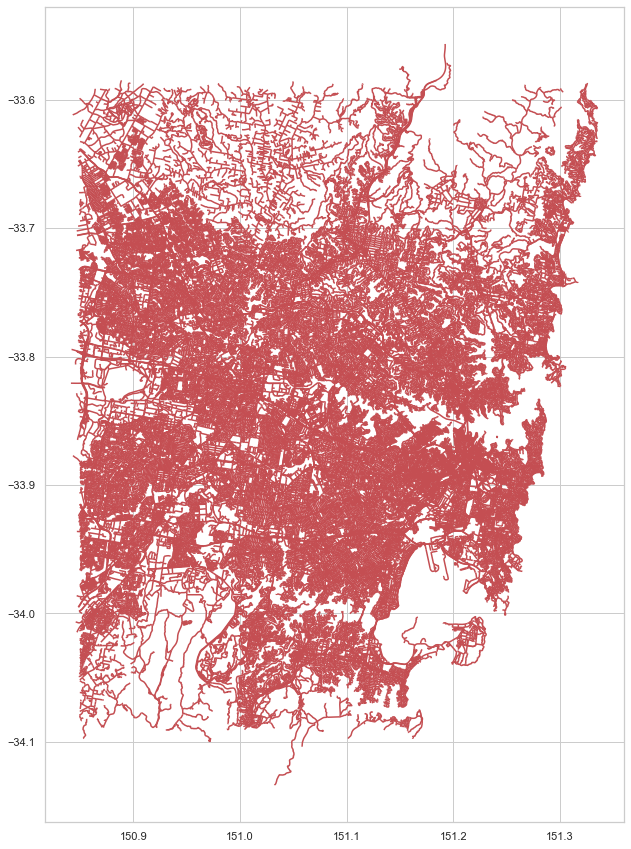

In [28]:
#plotting the streets to make sure everything is okay
fig, ax = plt.subplots(figsize=(15,15))

streets_gdf.plot(ax=ax, marker='o', color='r', markersize=15, alpha=1)

## `Merging The Road Segment Data with The Labeled GTFS-R Data `

In [29]:
#adding a buffer to the road segment data
street_index = streets_gdf.geometry.buffer(0.001).sindex

In [ ]:
# getting the roads that intersect with each point
for route_id in gdf.route_id.unique():
    data = gdf[gdf["route_id"] == route_id]
    gdf.loc[gdf["route_id"] == route_id, 'intersected_roads_list'] = data.geometry.apply(lambda x: street_index.query(x, predicate="intersects"))


In [32]:
# get number of intersections
gdf["number_of_intersections"] = gdf["intersected_roads_list"].apply(lambda x: len(x))

In [33]:
# get the closest street to the point(the streets ids are ordered according to the distance)
gdf["road_intersection_index"] = gdf["intersected_roads_list"].str[0]

In [34]:
#roads with 0 intersections
zero_intersections = gdf[gdf["number_of_intersections"]==0]
zero_intersections

,timestamp,trip_id,route_id,starttime,latitude,longitude,bearing,speed,zero_speed,is_at_stop,label,geometry,intersected_roads_list,number_of_intersections,road_intersection_index
795,1621296019,1234154,2441_400,09:07:00,-33.96889,151.22580,185.00000,0.00000,1,0,0,POINT (151.22579 -33.96890),[],0,NaN
1136,1621296019,1234154,2441_400,09:07:00,-33.96889,151.22580,185.00000,0.00000,1,0,0,POINT (151.22579 -33.96890),[],0,NaN
184935,1621304972,1333070,2441_400,12:22:00,-33.90175,151.24979,289.00000,11.00000,0,0,0,POINT (151.24978 -33.90176),[],0,NaN
185220,1621304988,1333070,2441_400,12:22:00,-33.90169,151.24799,286.00000,8.80000,0,0,0,POINT (151.24798 -33.90170),[],0,NaN
185509,1621305003,1333070,2441_400,12:22:00,-33.90163,151.24763,286.00000,0.00000,1,0,0,POINT (151.24762 -33.90165),[],0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320763,1621380377,1355818,2439_501,08:52:00,-33.84274,151.13954,286.00000,13.60000,0,0,0,POINT (151.13953 -33.84275),[],0,NaN
1340726,1621381137,1355760,2439_501,09:07:00,-33.84398,151.14288,254.00000,13.40000,0,0,0,POINT (151.14287 -33.84399),[],0,NaN
1341090,1621381152,1355760,2439_501,09:07:00,-33.84436,151.14113,248.00000,5.40000,0,0,0,POINT (151.14112 -33.84437),[],0,NaN
1341455,1621381167,1355760,2439_501,09:07:00,-33.84437,151.14108,258.00000,0.00000,1,0,0,POINT (151.14107 -33.84438),[],0,NaN


In [35]:
#since there isn't much points with no intersection, these points were discarded
gdf = gdf.dropna()

### `Checking if the streets are really ordered according to distance by example`

<AxesSubplot:>

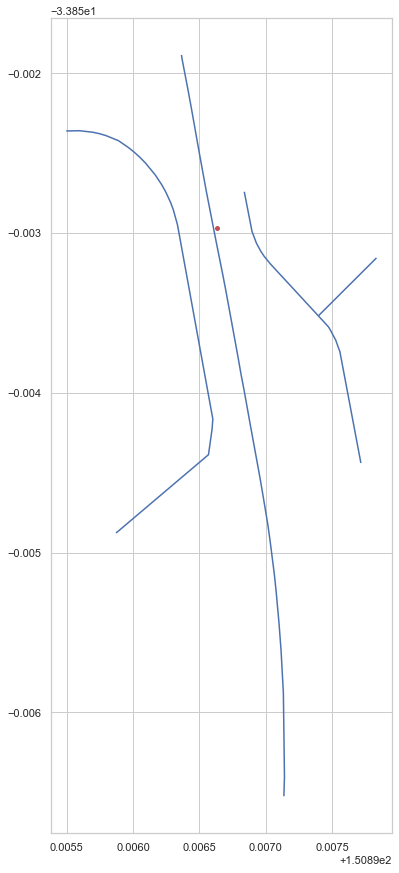

In [36]:

fig, ax = plt.subplots(figsize=(15,15))

gdf[gdf.index==2].plot(ax=ax, marker='o', color='r', markersize=15, alpha=1)
streets_gdf[streets_gdf.index.isin([53547, 137512, 137493, 137550, 137547])].plot(ax=ax, alpha=1)


<AxesSubplot:>

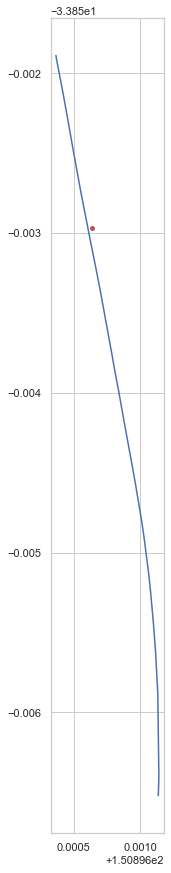

In [37]:
fig, ax = plt.subplots(figsize=(15,15))

gdf[gdf.index==2].plot(ax=ax, marker='o', color='r', markersize=15, alpha=1)
streets_gdf[streets_gdf.index.isin([53547])].plot(ax=ax, alpha=1)


In [38]:
#merging the road segment streets data with the GTFS-R labeled data
gdf = pd.merge(gdf, streets_gdf.drop('geometry', axis=1), left_on = 'road_intersection_index', right_index=True, how = 'left')


In [39]:
# drop columns that aren't needed in the next steps
gdf = gdf.drop(["is_at_stop", "intersected_roads_list", "number_of_intersections", "road_intersection_index", "msoid"], axis=1)

In [41]:
gdf.to_csv("Data_Engineering_step1.csv")

## `Step-2: Time values, and off-track detection`

In [2]:
gdf = pd.read_csv("Data_Engineering_step1.csv", index_col = 0)

In [6]:
#projecting the data
gdf = geopandas.GeoDataFrame(gdf.drop('geometry', axis=1), crs = 4326, geometry= geopandas.points_from_xy(gdf.longitude, gdf.latitude))
gdf = gdf.to_crs(4283)

In [7]:
#getting hour minute second values from timestamp 
gdf["hour"] = gdf.timestamp.apply(lambda epoch: datetime.datetime.fromtimestamp(epoch).strftime("%H") ).astype(int)
gdf["minutes"] = gdf.timestamp.apply(lambda epoch: datetime.datetime.fromtimestamp(epoch).strftime("%M") ).astype(int)
gdf["seconds"] = gdf.timestamp.apply(lambda epoch: datetime.datetime.fromtimestamp(epoch).strftime("%S") ).astype(int)

In [8]:
gdf.head()

,timestamp,trip_id,route_id,starttime,latitude,longitude,bearing,speed,zero_speed,label,urbanity,relevance,surface,roadontype,functionhierarchy,operationalstatus,roadnametype,roadnamesuffix,geometry,hour,minutes,seconds
0,1621295990,1304262,2435_T80,09:40:00,-33.83699,150.92494,281.00000,0.00000,1,1,U,6,1,1,10,1,NaN,NaN,POINT (150.92493 -33.83700),2,59,50
1,1621295989,1353322,2435_804,08:08:00,-33.82224,150.99547,10.00000,0.00000,1,1,U,6,1,1,3,1,STREET,NaN,POINT (150.99546 -33.82225),2,59,49
2,1621295988,1304261,2435_T80,09:30:00,-33.85296,150.89664,170.00000,12.40000,0,0,U,6,1,1,10,1,NaN,NaN,POINT (150.89663 -33.85297),2,59,48
3,1621295992,1304226,2435_T80,09:10:00,-33.92765,150.88275,88.00000,8.20000,0,0,U,6,1,1,6,1,ROAD,NaN,POINT (150.88274 -33.92766),2,59,52
4,1621295990,1304227,2435_T80,09:20:00,-33.90761,150.87553,185.00000,1.60000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.87552 -33.90762),2,59,50


In [9]:
# there's a 7 hours difference between the epochs whivh are in GMT and the starttime, so the hours value was edited
gdf["hour"] = (gdf["hour"]+7)%24

In [10]:
gdf.describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,label,relevance,surface,roadontype,functionhierarchy,operationalstatus,hour,minutes,seconds
count,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000
mean,1621334660.73755,-33.86123,151.14399,172.61607,5.40560,0.32985,0.24500,6.06612,1.00622,1.04480,5.32308,1.00111,13.06145,29.76351,29.54709
std,27869.64491,0.06918,0.11555,105.01509,5.30144,0.47016,0.43009,0.42532,0.14000,0.34769,1.90111,0.04714,4.93744,17.29949,17.24712
min,1621295749.00000,-34.08822,150.85068,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000
25%,1621312878.00000,-33.90277,151.04279,89.00000,0.00000,0.00000,0.00000,6.00000,1.00000,1.00000,3.00000,1.00000,9.00000,15.00000,15.00000
50%,1621325427.00000,-33.88001,151.18010,179.00000,4.60000,0.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,13.00000,30.00000,29.00000
75%,1621369171.00000,-33.82405,151.23800,268.00000,9.70000,1.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,17.00000,45.00000,44.00000
max,1621382381.00000,-33.59224,151.33432,360.00000,28.00000,1.00000,1.00000,7.00000,3.00000,8.00000,11.00000,3.00000,23.00000,59.00000,59.00000


In [11]:
#sorting values by trip Id and timestamp
gdf = gdf.sort_values(["trip_id", "timestamp"], ascending = (False, False))

In [12]:
gdf

,timestamp,trip_id,route_id,starttime,latitude,longitude,bearing,speed,zero_speed,label,urbanity,relevance,surface,roadontype,functionhierarchy,operationalstatus,roadnametype,roadnamesuffix,geometry,hour,minutes,seconds
1370974,1621382375,982558,2459_423,09:39:00,-33.88505,151.19464,198.00000,0.30000,0,0,U,7,1,1,2,1,ROAD,NaN,POINT (151.19463 -33.88506),9,59,35
1370641,1621382360,982558,2459_423,09:39:00,-33.88458,151.19495,264.00000,2.70000,0,0,U,7,1,1,2,1,ROAD,NaN,POINT (151.19494 -33.88459),9,59,20
1370309,1621382345,982558,2459_423,09:39:00,-33.88457,151.19507,267.00000,0.00000,1,1,U,7,1,1,2,1,ROAD,NaN,POINT (151.19506 -33.88458),9,59,5
1369977,1621382330,982558,2459_423,09:39:00,-33.88457,151.19507,267.00000,0.00000,1,1,U,7,1,1,2,1,ROAD,NaN,POINT (151.19506 -33.88458),9,58,50
1369644,1621382315,982558,2459_423,09:39:00,-33.88457,151.19516,267.00000,6.00000,0,0,U,7,1,1,2,1,ROAD,NaN,POINT (151.19515 -33.88458),9,58,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918204,1621339542,708241,2435_804,21:48:00,-33.86239,150.95712,218.00000,14.80000,0,0,U,6,1,1,5,1,STREET,NORTH,POINT (150.95711 -33.86240),22,5,42
918088,1621339521,708241,2435_804,21:48:00,-33.85962,150.95802,194.00000,16.60000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.95801 -33.85963),22,5,21
917970,1621339510,708241,2435_804,21:48:00,-33.85782,150.95859,194.00000,13.30000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.95858 -33.85783),22,5,10
917854,1621339496,708241,2435_804,21:48:00,-33.85619,150.95906,194.00000,17.40000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.95905 -33.85621),22,4,56


In [13]:
# getting the speed of the previous record
gdf['prev_speed'] = gdf.groupby('trip_id')['speed'].shift()

In [14]:
#if the record is the first record in a trip, put the value to be -1
gdf['prev_speed'] = gdf['prev_speed'].fillna(-1)

In [15]:
gdf[gdf["label"]==1].describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,label,relevance,surface,roadontype,functionhierarchy,operationalstatus,hour,minutes,seconds,prev_speed
count,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000,335843.00000
mean,1621334132.29487,-33.86468,151.15287,169.08819,0.00000,1.00000,1.00000,6.04915,1.01180,1.06820,5.54547,1.00111,12.99968,29.75309,29.55020,2.20768
std,28090.48968,0.06514,0.11037,103.36028,0.00000,0.00000,0.00000,0.34548,0.15871,0.49313,1.93028,0.04718,4.78752,17.29132,17.29714,3.61361
min,1621295797.00000,-34.03266,150.85986,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,-1.00000
25%,1621312270.00000,-33.89875,151.09148,89.00000,0.00000,1.00000,1.00000,6.00000,1.00000,1.00000,5.00000,1.00000,9.00000,15.00000,15.00000,0.00000
50%,1621324411.00000,-33.88134,151.19203,180.00000,0.00000,1.00000,1.00000,6.00000,1.00000,1.00000,6.00000,1.00000,13.00000,30.00000,29.00000,0.00000
75%,1621369426.50000,-33.83169,151.23978,262.00000,0.00000,1.00000,1.00000,6.00000,1.00000,1.00000,6.00000,1.00000,17.00000,45.00000,45.00000,3.80000
max,1621382381.00000,-33.59227,151.33408,360.00000,0.00000,1.00000,1.00000,7.00000,2.00000,7.00000,11.00000,3.00000,23.00000,59.00000,59.00000,21.90000


In [16]:
gdf.describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,label,relevance,surface,roadontype,functionhierarchy,operationalstatus,hour,minutes,seconds,prev_speed
count,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000
mean,1621334660.73755,-33.86123,151.14399,172.61607,5.40560,0.32985,0.24500,6.06612,1.00622,1.04480,5.32308,1.00111,13.06145,29.76351,29.54709,5.38356
std,27869.64491,0.06918,0.11555,105.01509,5.30144,0.47016,0.43009,0.42532,0.14000,0.34769,1.90111,0.04714,4.93744,17.29949,17.24712,5.30699
min,1621295749.00000,-34.08822,150.85068,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,-1.00000
25%,1621312878.00000,-33.90277,151.04279,89.00000,0.00000,0.00000,0.00000,6.00000,1.00000,1.00000,3.00000,1.00000,9.00000,15.00000,15.00000,0.00000
50%,1621325427.00000,-33.88001,151.18010,179.00000,4.60000,0.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,13.00000,30.00000,29.00000,4.60000
75%,1621369171.00000,-33.82405,151.23800,268.00000,9.70000,1.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,17.00000,45.00000,44.00000,9.70000
max,1621382381.00000,-33.59224,151.33432,360.00000,28.00000,1.00000,1.00000,7.00000,3.00000,8.00000,11.00000,3.00000,23.00000,59.00000,59.00000,28.00000


In [19]:
# getting the stop times data to compare it to the hour and minute values in thr GTFS-R
stop_times = pd.read_csv ('latest/stop_times.txt')
stop_times["trip_id"] = stop_times["trip_id"].astype(str)
stop_times = stop_times[stop_times["trip_id"].isin(gdf.trip_id.unique())]
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_note
1388059,1049226,07:35:00,07:35:00,2176253,1,NaN,0,0,0.00000,1,NaN
1388060,1049226,07:37:00,07:37:00,2176197,2,NaN,0,0,658.90000,0,NaN
1388061,1049226,07:38:00,07:38:00,2176198,3,NaN,0,0,1014.56000,0,NaN
1388062,1049226,07:39:00,07:39:00,2176199,4,NaN,0,0,1367.22000,0,NaN
1388063,1049226,07:40:00,07:40:00,2176200,5,NaN,0,0,1754.23000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4874669,1358609,18:38:00,18:38:00,202511,37,NaN,0,0,11535.42000,1,NaN
4874670,1358609,18:39:00,18:39:00,202512,38,NaN,0,0,11854.13000,0,NaN
4874671,1358609,18:42:00,18:42:00,202238,39,NaN,0,0,12598.64000,1,NaN
4874672,1358609,18:45:00,18:45:00,202240,40,NaN,0,0,13050.91000,0,NaN


In [21]:
#adding hour and minute to the stop times data
stop_times["hour"] = stop_times.arrival_time.apply(lambda epoch: datetime.datetime.strptime(epoch, "%H:%M:%S").strftime("%H") ).astype(int)
stop_times["minutes"] = stop_times.arrival_time.apply(lambda epoch: datetime.datetime.strptime(epoch, "%H:%M:%S").strftime("%M") ).astype(int)


In [40]:
#merge the GTFS-R data with the stops to get which points had the same time as the organized stops(within the same minute)
merged_data_with_stop_times = gdf.reset_index().merge(stop_times, how='left', on = ['trip_id','hour', 'minutes'], indicator= True)[["index", "_merge"]]
merged_data_with_stop_times

,index,_merge
0,1370974,both
1,1370641,both
2,1370309,both
3,1369977,both
4,1369644,both
...,...,...
1482865,918204,left_only
1482866,918088,left_only
1482867,917970,left_only
1482868,917854,left_only


In [49]:
#indexes of records in GTFS-R with no stop times scheduled
not_stop_times = merged_data_with_stop_times[merged_data_with_stop_times["_merge"]=="left_only"]["index"]

In [50]:
not_stop_times

7          1368637
8          1368306
9          1367976
10         1367646
11         1367317
            ...   
1482865     918204
1482866     918088
1482867     917970
1482868     917854
1482869     917740
Name: index, Length: 776342, dtype: int64

In [48]:
gdf["is_within_a_stop_time"] = 1

In [51]:
gdf.loc[gdf.index.isin(not_stop_times), 'is_within_a_stop_time'] = 0

In [53]:
gdf

,timestamp,trip_id,route_id,starttime,latitude,longitude,bearing,speed,zero_speed,label,urbanity,relevance,surface,roadontype,functionhierarchy,operationalstatus,roadnametype,roadnamesuffix,geometry,hour,minutes,seconds,prev_speed,is_within_a_stop_time
1370974,1621382375,982558,2459_423,09:39:00,-33.88505,151.19464,198.00000,0.30000,0,0,U,7,1,1,2,1,ROAD,NaN,POINT (151.19463 -33.88506),9,59,35,-1.00000,1
1370641,1621382360,982558,2459_423,09:39:00,-33.88458,151.19495,264.00000,2.70000,0,0,U,7,1,1,2,1,ROAD,NaN,POINT (151.19494 -33.88459),9,59,20,0.30000,1
1370309,1621382345,982558,2459_423,09:39:00,-33.88457,151.19507,267.00000,0.00000,1,1,U,7,1,1,2,1,ROAD,NaN,POINT (151.19506 -33.88458),9,59,5,2.70000,1
1369977,1621382330,982558,2459_423,09:39:00,-33.88457,151.19507,267.00000,0.00000,1,1,U,7,1,1,2,1,ROAD,NaN,POINT (151.19506 -33.88458),9,58,50,0.00000,1
1369644,1621382315,982558,2459_423,09:39:00,-33.88457,151.19516,267.00000,6.00000,0,0,U,7,1,1,2,1,ROAD,NaN,POINT (151.19515 -33.88458),9,58,35,0.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918204,1621339542,708241,2435_804,21:48:00,-33.86239,150.95712,218.00000,14.80000,0,0,U,6,1,1,5,1,STREET,NORTH,POINT (150.95711 -33.86240),22,5,42,14.90000,0
918088,1621339521,708241,2435_804,21:48:00,-33.85962,150.95802,194.00000,16.60000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.95801 -33.85963),22,5,21,14.80000,0
917970,1621339510,708241,2435_804,21:48:00,-33.85782,150.95859,194.00000,13.30000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.95858 -33.85783),22,5,10,16.60000,0
917854,1621339496,708241,2435_804,21:48:00,-33.85619,150.95906,194.00000,17.40000,0,0,U,6,1,1,5,1,ROAD,NaN,POINT (150.95905 -33.85621),22,4,56,13.30000,0


In [54]:
gdf.describe(include= "object")

,trip_id,route_id,starttime,urbanity,roadnametype,roadnamesuffix
count,1370775,1370775,1370775,1370775,1154257,11767
unique,5231,20,1143,2,36,4
top,1382117,2441_333,16:40:00,U,STREET,EAST
freq,619,100931,6339,1336309,507262,9068


In [55]:
gdf.roadnametype.unique()

array(['ROAD', nan, 'STREET', 'AVENUE', 'PLACE', 'CRESCENT', 'LANE',
       'CLOSE', 'PARADE', 'DRIVE', 'SERVICEWAY', 'BOULEVARD', 'WALK',
       'GARDENS', 'HIGHWAY', 'MOTORWAY', 'CIRCUIT', 'COURT', 'PLAZA',
       'WAY', 'GROVE', 'SQUARE', 'TERRACE', 'TRACK', 'TRAIL', 'BYPASS',
       'FREEWAY', 'CIRCLE', 'EXPRESSWAY', 'DISTRIBUTOR', 'ROW', 'PARKWAY',
       'ESPLANADE', 'GATE', 'RETREAT', 'WALKWAY', 'MALL'], dtype=object)

In [58]:
gdf.roadnametype = gdf.roadnametype.fillna("non_of_the_above")

In [56]:
gdf.roadnamesuffix.unique()

array([nan, 'NORTH', 'EAST', 'SOUTH', 'WEST'], dtype=object)

In [61]:
# this column doesn't seem like it would contribute a significant affect on the goal so it will be discarded
gdf = gdf.drop('roadnamesuffix', axis=1)

In [64]:
gdf.describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,label,relevance,surface,roadontype,functionhierarchy,operationalstatus,hour,minutes,seconds,prev_speed,is_within_a_stop_time
count,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000
mean,1621334660.73755,-33.86123,151.14399,172.61607,5.40560,0.32985,0.24500,6.06612,1.00622,1.04480,5.32308,1.00111,13.06145,29.76351,29.54709,5.38356,0.43365
std,27869.64491,0.06918,0.11555,105.01509,5.30144,0.47016,0.43009,0.42532,0.14000,0.34769,1.90111,0.04714,4.93744,17.29949,17.24712,5.30699,0.49558
min,1621295749.00000,-34.08822,150.85068,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,-1.00000,0.00000
25%,1621312878.00000,-33.90277,151.04279,89.00000,0.00000,0.00000,0.00000,6.00000,1.00000,1.00000,3.00000,1.00000,9.00000,15.00000,15.00000,0.00000,0.00000
50%,1621325427.00000,-33.88001,151.18010,179.00000,4.60000,0.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,13.00000,30.00000,29.00000,4.60000,0.00000
75%,1621369171.00000,-33.82405,151.23800,268.00000,9.70000,1.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,17.00000,45.00000,44.00000,9.70000,1.00000
max,1621382381.00000,-33.59224,151.33432,360.00000,28.00000,1.00000,1.00000,7.00000,3.00000,8.00000,11.00000,3.00000,23.00000,59.00000,59.00000,28.00000,1.00000


In [63]:
gdf.to_csv("Data_Engineering_step2.csv")

## `Step -3: Splitting The Data to off-track points and on-track points`

In [199]:
shapes = pd.read_csv ('latest/shapes.txt')
trips = pd.read_csv('latest/trips.txt')[["trip_id", "shape_id"]].astype(str)
trips = trips[trips["trip_id"].isin(gdf.trip_id.unique())]
shapes.shape_id = shapes.shape_id.astype(str)
shapes = shapes[shapes["shape_id"].isin(trips.shape_id.unique())]
shapes["geometry"] = geopandas.points_from_xy(shapes.shape_pt_lon, shapes.shape_pt_lat)
streets = shapes.groupby("shape_id").agg(
     geometry = pd.NamedAgg(column='geometry', aggfunc = lambda x: LineString(x.values))
    ).reset_index()
streets = geopandas.GeoDataFrame(streets[["shape_id"]], crs = 4326, geometry=streets["geometry"])
streets = streets.to_crs(4283)

streets = streets.merge(trips, how="left")
streets = streets.merge(trip_and_route_mapping, how="left")

# the result is a dataframe with the roads for each route
streets = streets[["shape_id", "geometry", "route_id"]].drop_duplicates()

(150.84939802236667, 151.01784103547558)

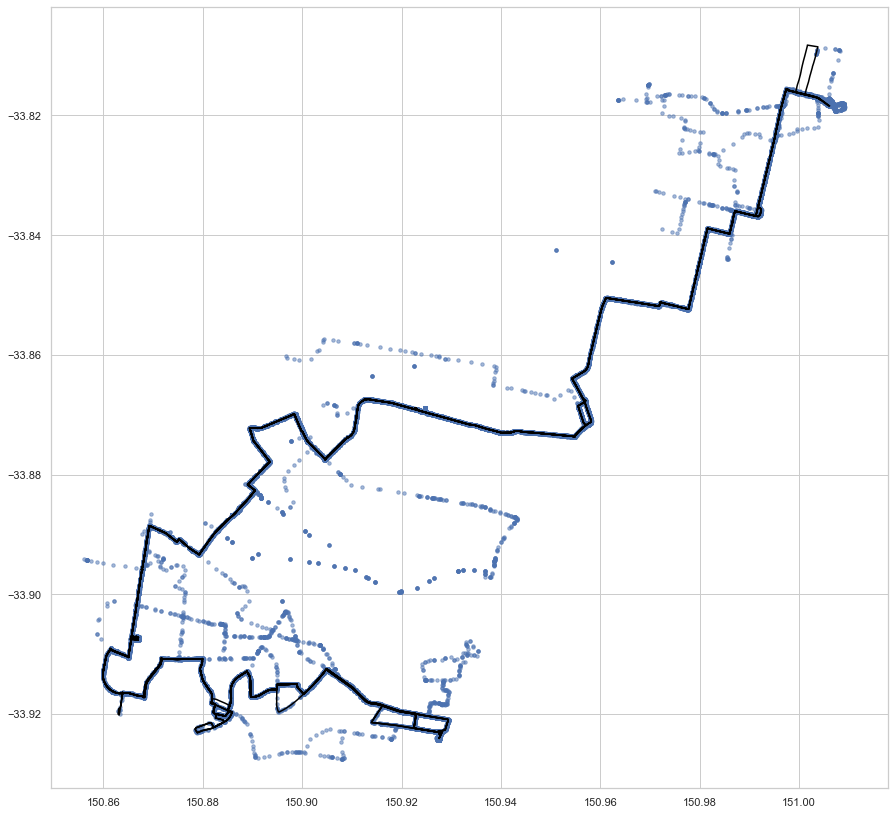

In [121]:
fig, ax = plt.subplots(figsize=(15,15))
gdf[gdf["route_id"]=="2435_804"].plot(ax=ax, marker='o', color='b', markersize=12, alpha=0.5)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()


streets[streets["route_id"]=="2435_804"].plot(ax=ax, color='black', alpha=1)
plt.ylim([ymin + 0.001, ymax + 0.001])
plt.xlim([xmin + 0.001, xmax + 0.001])


#### `the off-track points are the ones that don't intersect with the black line`

In [29]:
# caculating if each point intersects with the streets of it's coresponding route or not
for route_id in gdf.route_id.unique():
    data = gdf[gdf["route_id"] == route_id]
    streets_of_route_index = streets[streets["route_id"]==route_id].geometry.buffer(0.001).sindex
    gdf.loc[gdf["route_id"] == route_id, 'intersection_with_track_count'] = data.geometry.apply(lambda x: len(streets_of_route_index.query(x, predicate="intersects")))

In [128]:
gdf['off_track'] = np.where(gdf['intersection_with_track_count']==0, 1, 0)
gdf.describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,label,relevance,surface,roadontype,functionhierarchy,operationalstatus,hour,minutes,seconds,prev_speed,is_within_a_stop_time,intersection_with_track_count,off_track
count,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000,1370775.00000
mean,1621334660.73755,-33.86123,151.14399,172.61607,5.40560,0.32985,0.24500,6.06612,1.00622,1.04480,5.32308,1.00111,13.06145,29.76351,29.54709,5.38356,0.43365,7.16295,0.05010
std,27869.64491,0.06918,0.11555,105.01509,5.30144,0.47016,0.43009,0.42532,0.14000,0.34769,1.90111,0.04714,4.93744,17.29949,17.24712,5.30699,0.49558,4.77030,0.21815
min,1621295749.00000,-34.08822,150.85068,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,-1.00000,0.00000,0.00000,0.00000
25%,1621312878.00000,-33.90277,151.04279,89.00000,0.00000,0.00000,0.00000,6.00000,1.00000,1.00000,3.00000,1.00000,9.00000,15.00000,15.00000,0.00000,0.00000,4.00000,0.00000
50%,1621325427.00000,-33.88001,151.18010,179.00000,4.60000,0.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,13.00000,30.00000,29.00000,4.60000,0.00000,6.00000,0.00000
75%,1621369171.00000,-33.82405,151.23800,268.00000,9.70000,1.00000,0.00000,6.00000,1.00000,1.00000,6.00000,1.00000,17.00000,45.00000,44.00000,9.70000,1.00000,10.00000,0.00000
max,1621382381.00000,-33.59224,151.33432,360.00000,28.00000,1.00000,1.00000,7.00000,3.00000,8.00000,11.00000,3.00000,23.00000,59.00000,59.00000,28.00000,1.00000,24.00000,1.00000


In [130]:
gdf.to_csv("Data_Engineering_step3.csv")

## `Final Data Engineering and EDA`

In [91]:
gdf = pd.read_csv("Data_Engineering_step3.csv", index_col = 0)

In [92]:
gdf.columns

Index(['timestamp', 'trip_id', 'route_id', 'starttime', 'latitude',
       'longitude', 'bearing', 'speed', 'zero_speed', 'label', 'urbanity',
       'relevance', 'surface', 'roadontype', 'functionhierarchy',
       'operationalstatus', 'roadnametype', 'geometry', 'hour', 'minutes',
       'seconds', 'prev_speed', 'is_within_a_stop_time',
       'intersection_with_track_count', 'off_track'],
      dtype='object')

In [93]:
#get the speed of the next record 
gdf['next_speed'] = gdf.groupby('trip_id')['speed'].shift(-1)
gdf['next_speed'] = gdf['next_speed'].fillna(-1)


In [94]:
#get the speed of the previous to previous record
gdf['prev2_speed'] = gdf.groupby('trip_id')['speed'].shift(2)
gdf['prev2_speed'] = gdf['prev2_speed'].fillna(-1)


In [95]:
# one hot encoding tp prepare the data for the model
one_hot = pd.get_dummies(gdf['urbanity'], prefix='urbanity')
gdf = gdf.join(one_hot)


In [76]:
# save off-track data for later use
gdf[gdf["off_track"]==1].drop('off_track', axis=1).to_csv("off-track_data.csv")

In [96]:
# taking the on-track data only for modeling
gdf = gdf[gdf["off_track"]==0].drop('off_track', axis=1)

In [97]:
gdf

,timestamp,trip_id,route_id,starttime,latitude,longitude,bearing,speed,zero_speed,label,urbanity,relevance,surface,roadontype,functionhierarchy,operationalstatus,roadnametype,geometry,hour,minutes,seconds,prev_speed,is_within_a_stop_time,intersection_with_track_count,next_speed,prev2_speed,urbanity_S,urbanity_U
1370974,1621382375,982558,2459_423,09:39:00,-33.88505,151.19464,198.00000,0.30000,0,0,U,7,1,1,2,1,ROAD,POINT (151.1946345702738 -33.88506068526851),9,59,35,-1.00000,1,11.00000,2.70000,-1.00000,0,1
1370641,1621382360,982558,2459_423,09:39:00,-33.88458,151.19495,264.00000,2.70000,0,0,U,7,1,1,2,1,ROAD,POINT (151.1949445702554 -33.88459268524288),9,59,20,0.30000,1,11.00000,0.00000,-1.00000,0,1
1370309,1621382345,982558,2459_423,09:39:00,-33.88457,151.19507,267.00000,0.00000,1,1,U,7,1,1,2,1,ROAD,POINT (151.1950645702712 -33.88458268523173),9,59,5,2.70000,1,11.00000,0.00000,0.30000,0,1
1369977,1621382330,982558,2459_423,09:39:00,-33.88457,151.19507,267.00000,0.00000,1,1,U,7,1,1,2,1,ROAD,POINT (151.1950645702712 -33.88458268523173),9,58,50,0.00000,1,11.00000,6.00000,2.70000,0,1
1369644,1621382315,982558,2459_423,09:39:00,-33.88457,151.19516,267.00000,6.00000,0,0,U,7,1,1,2,1,ROAD,POINT (151.1951545702837 -33.88457968522336),9,58,35,0.00000,1,11.00000,5.20000,0.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918204,1621339542,708241,2435_804,21:48:00,-33.86239,150.95712,218.00000,14.80000,0,0,U,6,1,1,5,1,STREET,POINT (150.957114533241 -33.86240270748389),22,5,42,14.90000,0,12.00000,16.60000,3.30000,0,1
918088,1621339521,708241,2435_804,21:48:00,-33.85962,150.95802,194.00000,16.60000,0,0,U,6,1,1,5,1,ROAD,POINT (150.9580145330022 -33.85963270742012),22,5,21,14.80000,0,12.00000,13.30000,14.90000,0,1
917970,1621339510,708241,2435_804,21:48:00,-33.85782,150.95859,194.00000,13.30000,0,0,U,6,1,1,5,1,ROAD,POINT (150.9585845328449 -33.85783270738005),22,5,10,16.60000,0,12.00000,17.40000,14.80000,0,1
917854,1621339496,708241,2435_804,21:48:00,-33.85619,150.95906,194.00000,17.40000,0,0,U,6,1,1,5,1,ROAD,POINT (150.9590545326963 -33.85620670734801),22,4,56,13.30000,0,12.00000,18.20000,16.60000,0,1


In [98]:
#projecting the data
gdf = geopandas.GeoDataFrame(gdf.drop('geometry', axis=1), crs = 4326, geometry= geopandas.points_from_xy(gdf.longitude, gdf.latitude))
gdf = gdf.to_crs(4283)

### `EDA`

In [81]:
def distplotDistribution(data, column):
    '''
    plots 2 distribution plots of a column from a dataframe
    inputs: dataframe, column name
    output: distplot and boxplot
    '''
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    #casual customers distribution plots
    sns.distplot(data[column],ax=ax[0])
    data.boxplot(column, ax=ax[1])
    fig.show()

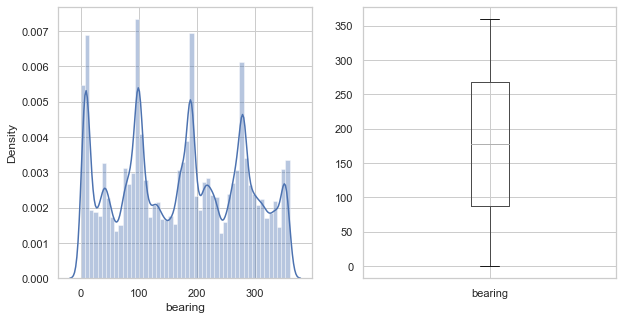

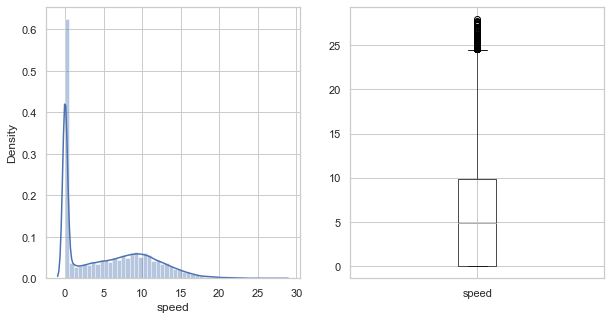

In [83]:
distplotDistribution(gdf, "bearing")
distplotDistribution(gdf, "speed")

<div class="alert alert-block alert-info">  
    <ul>
        <li>
bearing values seem to be well distributed, there's peaks on 90,180,270,360, which could mean that sometimes the angles get rounded up 
        </li>
        <li>
the speed is extremely skewed to the right to be 0, which makes sense since ther's a lot of stops</li> 
    </ul>
    
</div>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'ROAD'),
  Text(1, 0, 'non_of_the_above'),
  Text(2, 0, 'STREET'),
  Text(3, 0, 'AVENUE'),
  Text(4, 0, 'PLACE'),
  Text(5, 0, 'CRESCENT'),
  Text(6, 0, 'LANE'),
  Text(7, 0, 'CLOSE'),
  Text(8, 0, 'PARADE'),
  Text(9, 0, 'SERVICEWAY'),
  Text(10, 0, 'DRIVE'),
  Text(11, 0, 'BOULEVARD'),
  Text(12, 0, 'GARDENS'),
  Text(13, 0, 'CIRCUIT'),
  Text(14, 0, 'COURT'),
  Text(15, 0, 'MOTORWAY'),
  Text(16, 0, 'HIGHWAY'),
  Text(17, 0, 'PLAZA'),
  Text(18, 0, 'SQUARE'),
  Text(19, 0, 'GROVE'),
  Text(20, 0, 'WAY'),
  Text(21, 0, 'WALK'),
  Text(22, 0, 'FREEWAY'),
  Text(23, 0, 'CIRCLE'),
  Text(24, 0, 'TRAIL'),
  Text(25, 0, 'EXPRESSWAY'),
  Text(26, 0, 'DISTRIBUTOR'),
  Text(27, 0, 'ROW'),
  Text(28, 0, 'TERRACE'),
  Text(29, 0, 'PARKWAY'),
  Text(30, 0, 'ESPLANADE'),
  Text(31, 0, 'WALKWAY')])

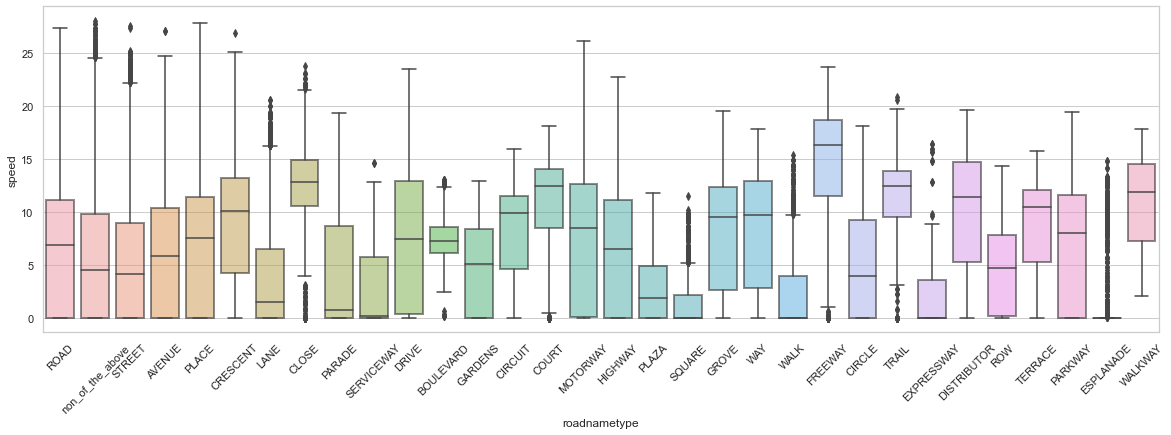

In [106]:
plt.figure(figsize = (20, 6))
ax = sns.boxplot(x='roadnametype', y='speed', data=gdf)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'ROAD'),
  Text(1, 0, 'non_of_the_above'),
  Text(2, 0, 'STREET'),
  Text(3, 0, 'AVENUE'),
  Text(4, 0, 'PLACE'),
  Text(5, 0, 'CRESCENT'),
  Text(6, 0, 'LANE'),
  Text(7, 0, 'CLOSE'),
  Text(8, 0, 'PARADE'),
  Text(9, 0, 'SERVICEWAY'),
  Text(10, 0, 'DRIVE'),
  Text(11, 0, 'BOULEVARD'),
  Text(12, 0, 'GARDENS'),
  Text(13, 0, 'CIRCUIT'),
  Text(14, 0, 'COURT'),
  Text(15, 0, 'MOTORWAY'),
  Text(16, 0, 'HIGHWAY'),
  Text(17, 0, 'PLAZA'),
  Text(18, 0, 'SQUARE'),
  Text(19, 0, 'GROVE'),
  Text(20, 0, 'WAY'),
  Text(21, 0, 'WALK'),
  Text(22, 0, 'FREEWAY'),
  Text(23, 0, 'CIRCLE'),
  Text(24, 0, 'TRAIL'),
  Text(25, 0, 'EXPRESSWAY'),
  Text(26, 0, 'DISTRIBUTOR'),
  Text(27, 0, 'ROW'),
  Text(28, 0, 'TERRACE'),
  Text(29, 0, 'PARKWAY'),
  Text(30, 0, 'ESPLANADE'),
  Text(31, 0, 'WALKWAY')])

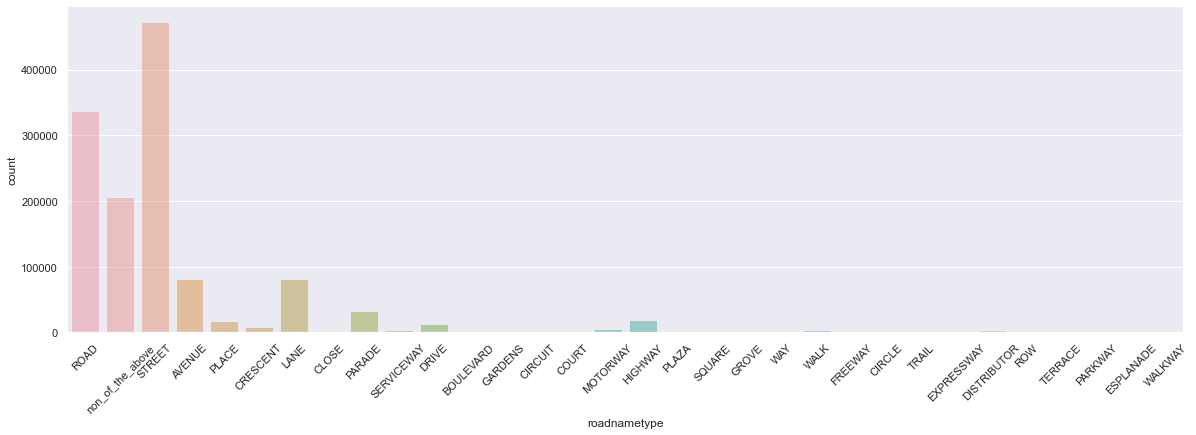

In [179]:
plt.figure(figsize = (20, 6))
ax =sns.countplot(x='roadnametype', data=gdf,alpha=.5,)
plt.xticks(rotation=45)

<div class="alert alert-block alert-info">  
    there isn't a lot of distribution in this column, so it will be discarded
    
</div>

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '5'),
  Text(4, 0, '7'),
  Text(5, 0, '8')])

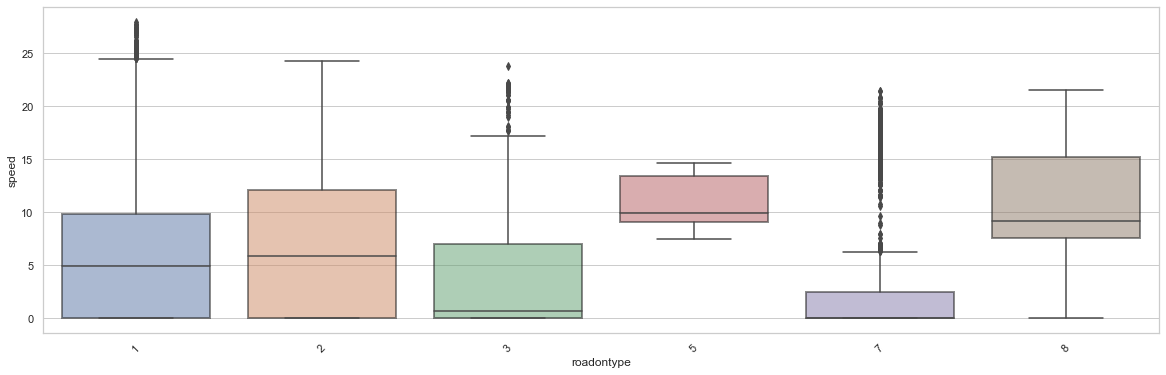

In [119]:
gdf["time_of_the_day"] = pd.cut(x=gdf['hour'], bins = [0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])
plt.figure(figsize = (20, 6))
ax = sns.boxplot(x='roadontype', y='speed', data=gdf)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)


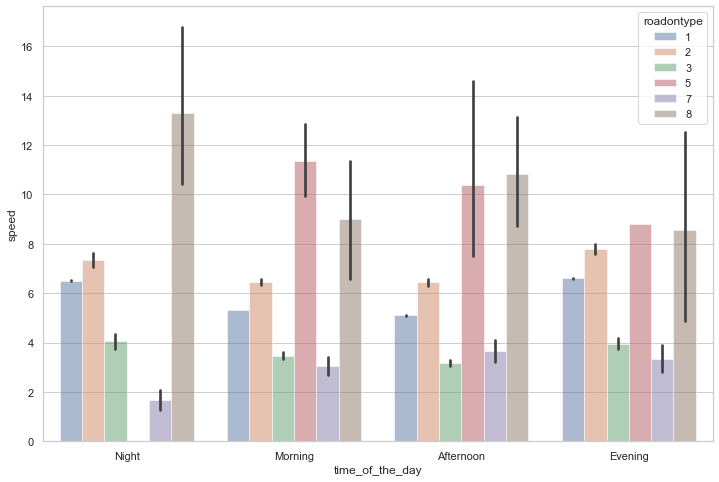

In [123]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='time_of_the_day', y='speed', hue='roadontype', data=gdf, alpha=.5, )

<div class="alert alert-block alert-info">  
    it seems like roads with types 8 and 5 have the highest speeds, so maybe they are highways? stops would be pretty unlikely in such streets let's check that out next
    
</div>

<AxesSubplot:xlabel='roadontype,label'>

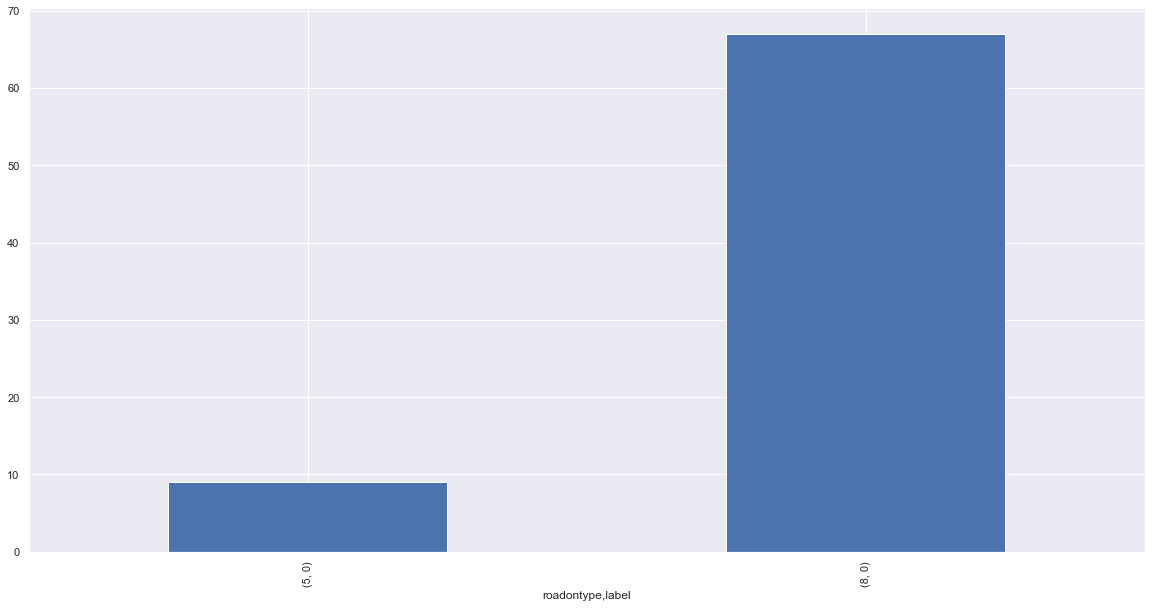

In [183]:
gdf[gdf["roadontype"].isin([8,5])].groupby('roadontype')['label'].value_counts().plot(kind = 'bar')

<div class="alert alert-block alert-info">  
    roads with types 8 and 5 have no stops at all as expected
    
</div>

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '6'), Text(3, 0, '7')])

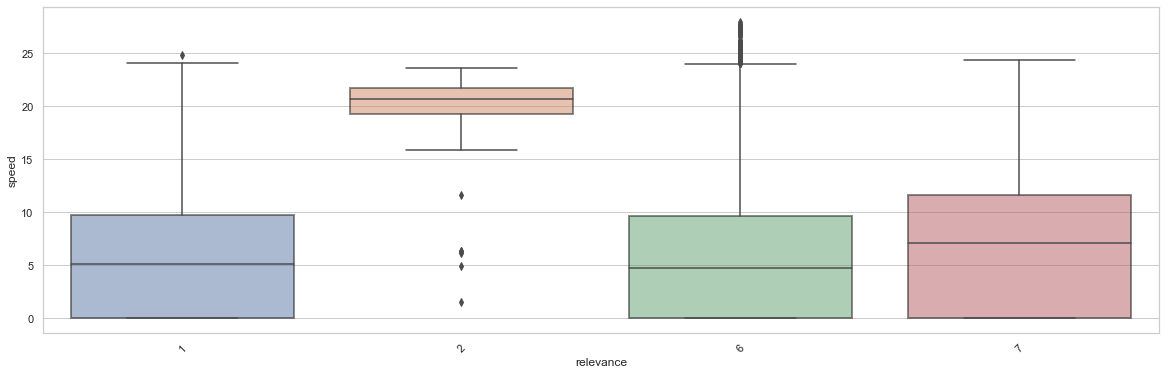

In [133]:
plt.figure(figsize = (20, 6))
ax = sns.boxplot(x='relevance', y='speed', data=gdf)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)


<AxesSubplot:xlabel='relevance,label'>

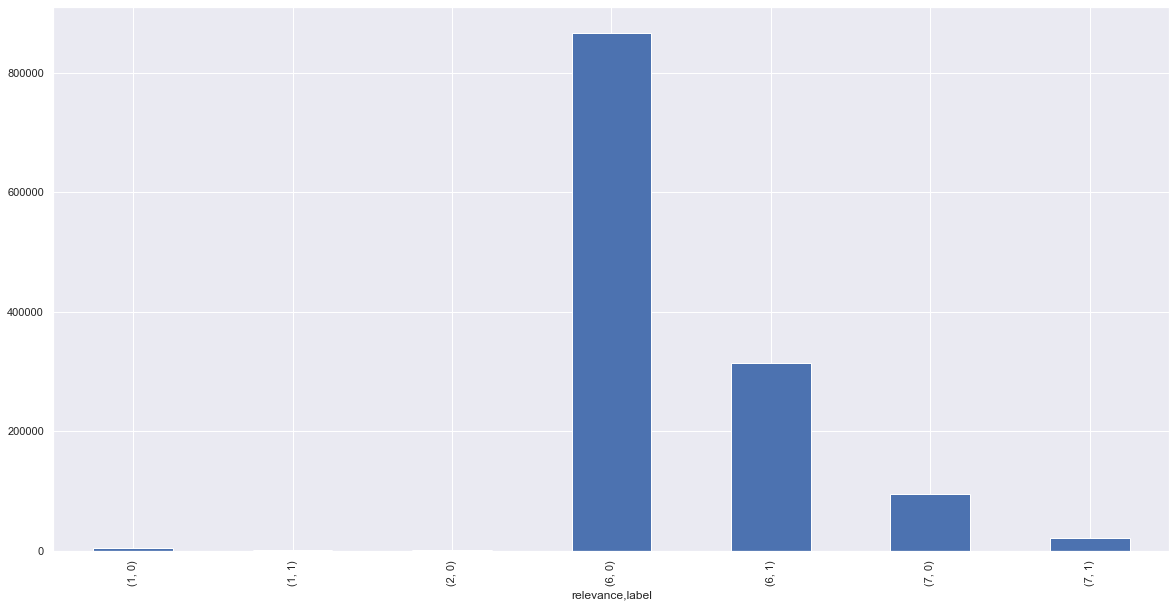

In [184]:
gdf.groupby('relevance')['label'].value_counts().plot(kind = 'bar')

<div class="alert alert-block alert-info">  
    roads with relevance 6 and 7 mostly have all of the stops in them unlike 1 and 2
    
</div>

<AxesSubplot:xlabel='hour'>

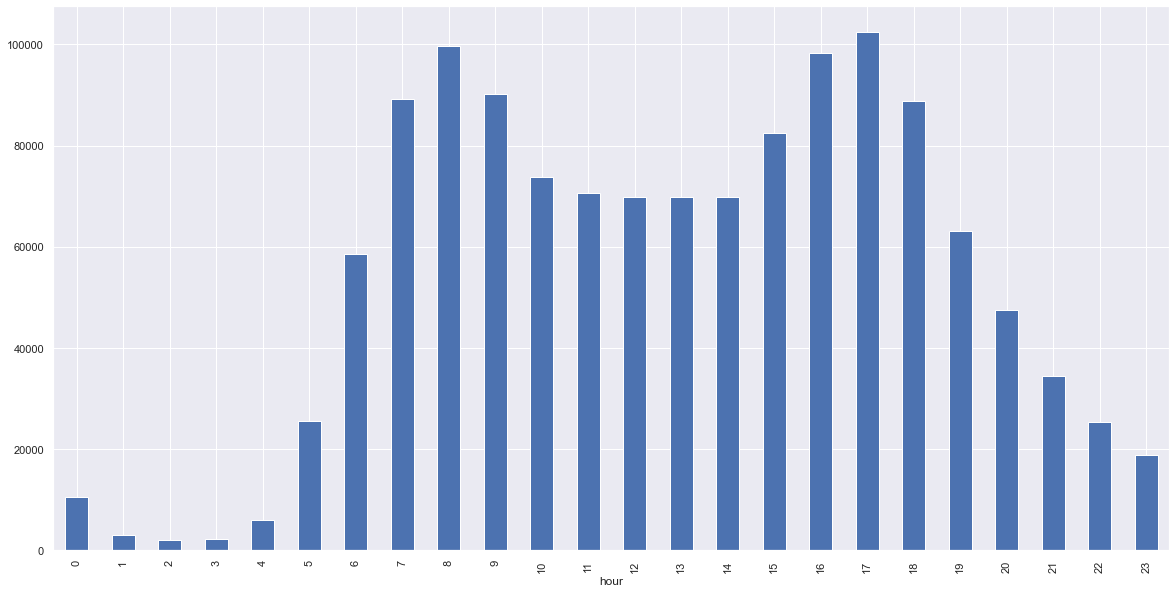

In [191]:
gdf.groupby('hour')["hour"].count().plot(kind = 'bar')

<div class="alert alert-block alert-info">  
   the hours distribution is as expected in transportation patterns, the peask are in the morning and around 5, when jobs typically start and end
    
</div>

<AxesSubplot:xlabel='functionhierarchy'>

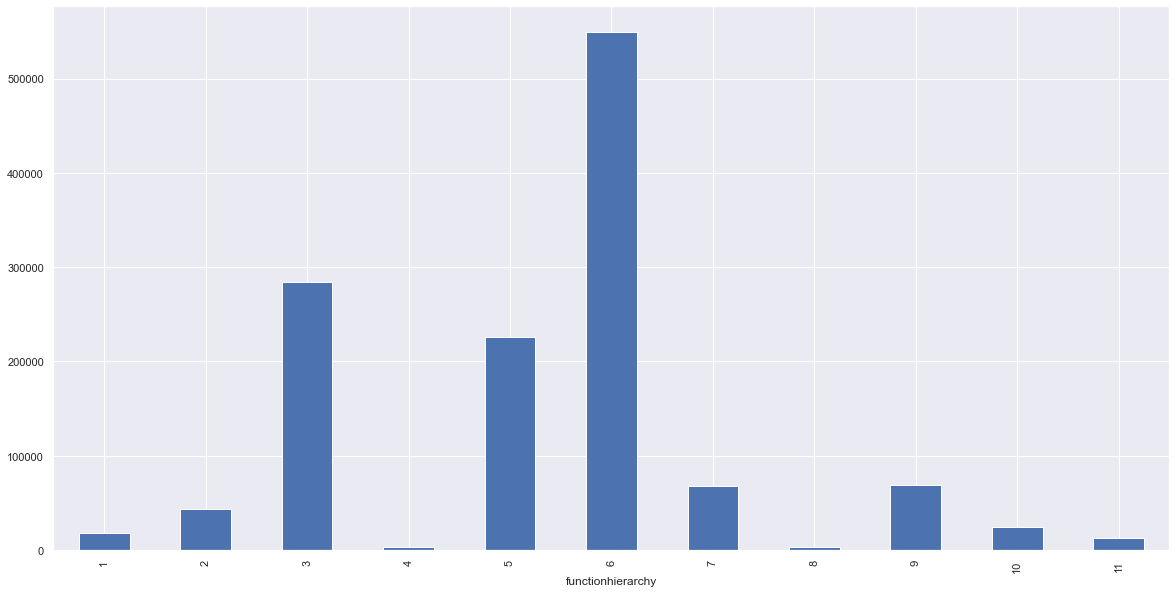

In [193]:
gdf.groupby('functionhierarchy')["functionhierarchy"].count().plot(kind = 'bar')

## `Modeling`

### `Random Forest Clasifier`

In [ ]:
# one hot encoding tp prepare the data for the model
one_hot = pd.get_dummies(gdf['urbanity'], prefix='urbanity')

gdf = gdf.drop(['urbanity', 'roadnametype'],axis = 1)

gdf = gdf.join(one_hot)


In [6]:
#choosing columns that will be included in the modeling stage
gdf = gdf[[ 'bearing', 'route_id', 'speed', 'zero_speed', 'urbanity', 'relevance', 'surface', 'roadontype', 'functionhierarchy',
       'operationalstatus', 'roadnametype', 'hour', 'minutes', 'seconds', 'prev_speed', 'is_within_a_stop_time', 'next_speed',
       'prev2_speed', 'off_track', 'label']]

In [12]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [13]:
# splitting the data on routes for training and testing
routes = gdf.route_id.unique()
train = gdf[gdf["route_id"].isin(routes[:15])] 
test = gdf[gdf["route_id"].isin(routes[15:])] 

In [14]:
X_train = train.drop(['label', 'route_id'], axis=1) # Features
y_train = train.label # Target variable

X_test = test.drop(['label', 'route_id'], axis=1) # Features
y_test = test.label # Target variable


In [28]:
rfc=RandomForestClassifier(random_state=42)

param = {'max_depth': [6,9, None], 
         'n_estimators':[50, 70, 100, 150], 
          'criterion' : ['gini', 'entropy'],
          'bootstrap':[True, False],
        }

rnd_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param, n_iter =10, cv=5, n_jobs = 7)
rnd_search.fit(X_train, y_train)

rnd_search.best_score_

0.9431320516796072

In [30]:
rnd_search.best_params_

{'n_estimators': 150,
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [36]:
rfc=RandomForestClassifier(random_state=42, n_estimators= 150,
 criterion= 'entropy',
 bootstrap= True)
rfc.fit(X_train, y_train)

In [39]:
y_pred = rfc.predict(X_test)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    269566
           1       0.81      0.93      0.87     90192

    accuracy                           0.93    359758
   macro avg       0.89      0.93      0.91    359758
weighted avg       0.94      0.93      0.93    359758



### `Off-Track Data`

In [57]:
off_track_data =gdf[gdf["off_track"]==1]

In [63]:
#choosing columns that will be included in the modeling stage
off_track_Tdata = off_track_data[[ 'bearing', 'route_id', 'speed', 'zero_speed', 'relevance', 'surface', 'roadontype', 'functionhierarchy',
       'operationalstatus', 'hour', 'minutes', 'seconds', 'prev_speed', 'is_within_a_stop_time', 'next_speed',
       'prev2_speed', 'label', "urbanity_S","urbanity_U"]]

In [64]:
off_track_y_pred = rfc.predict(off_track_Tdata.drop(['label', "route_id"], axis=1))

In [65]:
off_track_data.label = off_track_y_pred

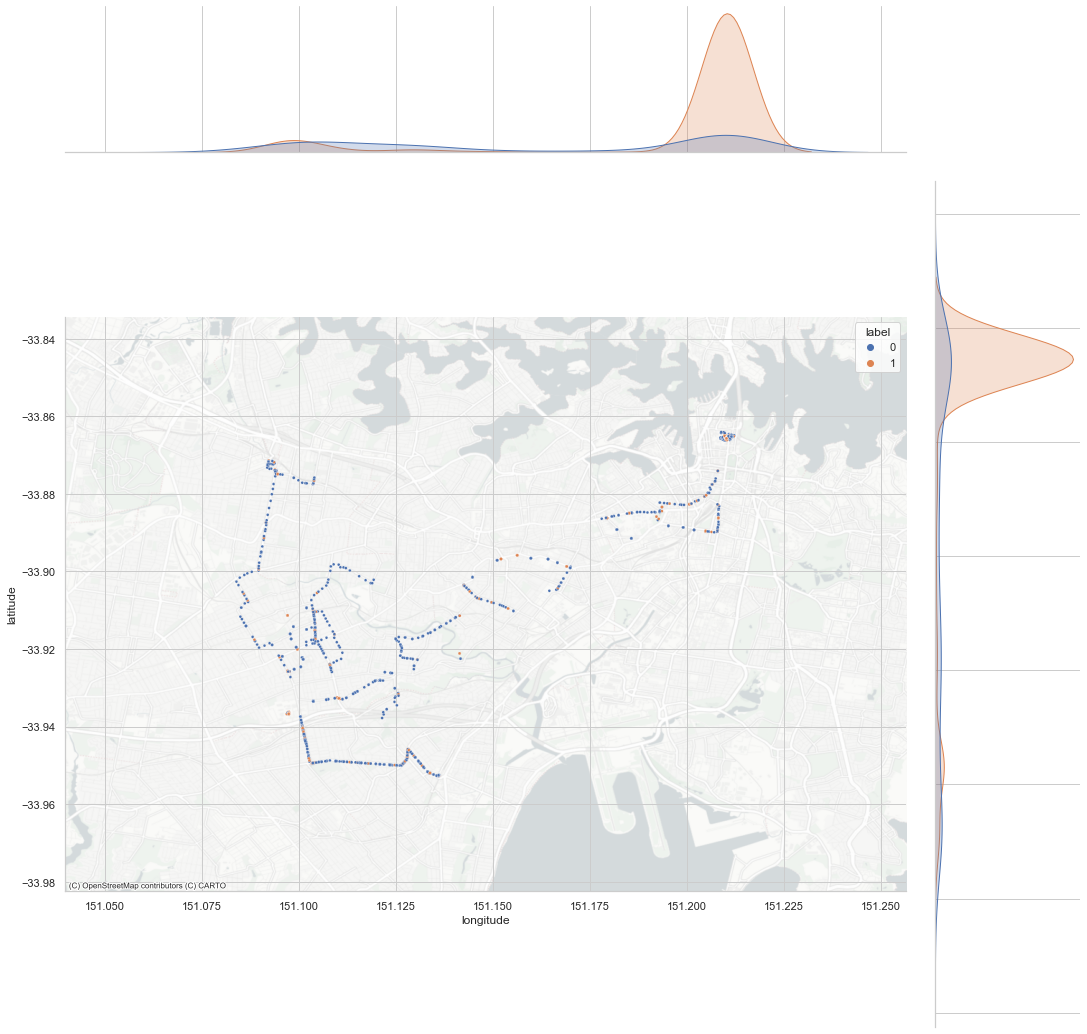

In [146]:
joint_axes = sns.jointplot(
    x='longitude', y='latitude', data=off_track_data[off_track_data["route_id"]=="2459_423"], s=8, height =15, alpha = 1, hue="label"
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4283",
    source=contextily.providers.CartoDB.PositronNoLabels
);